In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import uuid
import  matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import os


LOADING OF DATA

In [2]:
df = pd.read_csv(r'C:\My files\Case studies\loan_application_data.csv')
df.head()

,ApplicationDate,CreditScore,AnnualIncome,LoanAmount,EmploymentStatus,OutstandingDebt,EmploymentStartDate,LoanOutcome
0,2021-01-01 00:00:00.000000000,655,6306291,417034,Employed,159749,2011-11-24 19:42:42.126610048,Denied
1,2021-01-02 02:16:56.216216216,652,7555169,5730135,Self-Employed,334035,2006-12-25 19:23:45.596053728,Approved
2,2021-01-03 04:33:52.432432432,490,9578220,1886511,Unemployed,159927,2006-05-06 00:34:43.639353248,Approved
3,2021-01-04 06:50:48.648648648,759,7697704,9468833,Unemployed,3438,2009-01-22 19:20:12.496574400,Denied
4,2021-01-05 09:07:44.864864864,800,9040140,655286,Self-Employed,110166,2005-10-19 11:13:37.867909024,Approved


DATA PREPROCESSING:
in this section were going to explore throught the data and check for inconsistencies, missing values, errors, outliers and find the best possible way to trim and also clean it so as to make our data free from error or biases and  lastly we are going to develop a wrangle function to help with the cleaning of the dta at once.

In [3]:
#convert the object dtype to  datetime
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])
df['EmploymentStartDate'] = pd.to_datetime(df['EmploymentStartDate'], errors='coerce')


In [4]:
# converting the date difference to years and rounding it up to a whole digit
df['EmploymentLenght'] = round((df['ApplicationDate'] - df['EmploymentStartDate']).dt.days / 365.25)

df['ApplicationYear'] = df['ApplicationDate'].dt.year
df['ApplicationMonth'] = df['ApplicationDate'].dt.month
df['ApplicationDay'] = df['ApplicationDate'].dt.day
df['ApplicationWeekday'] = df['ApplicationDate'].dt.weekday  # Monday=0, Sunday=6
df['ApplicationDayOfYear'] = df['ApplicationDate'].dt.dayofyear

# Similarly for EmploymentStartDate
df['EmploymentStartYear'] = df['EmploymentStartDate'].dt.year
df['EmploymentStartMonth'] = df['EmploymentStartDate'].dt.month
df['EmploymentStartDay'] = df['EmploymentStartDate'].dt.day
df['EmploymentStartWeekday'] = df['EmploymentStartDate'].dt.weekday
df['EmploymentStartDayOfYear'] = df['EmploymentStartDate'].dt.dayofyear

In [5]:
# Format to desired string format
df['ApplicationDate'] = df['ApplicationDate'].dt.strftime('%m/%d/%Y')
df['EmploymentStartDate'] = df['EmploymentStartDate'].dt.strftime('%m/%d/%Y')
df.head()

,ApplicationDate,CreditScore,AnnualIncome,LoanAmount,EmploymentStatus,OutstandingDebt,EmploymentStartDate,LoanOutcome,EmploymentLenght,ApplicationYear,ApplicationMonth,ApplicationDay,ApplicationWeekday,ApplicationDayOfYear,EmploymentStartYear,EmploymentStartMonth,EmploymentStartDay,EmploymentStartWeekday,EmploymentStartDayOfYear
0,01/01/2021,655,6306291,417034,Employed,159749,11/24/2011,Denied,9.0,2021,1,1,4,1,2011,11,24,3,328
1,01/02/2021,652,7555169,5730135,Self-Employed,334035,12/25/2006,Approved,14.0,2021,1,2,5,2,2006,12,25,0,359
2,01/03/2021,490,9578220,1886511,Unemployed,159927,05/06/2006,Approved,15.0,2021,1,3,6,3,2006,5,6,5,126
3,01/04/2021,759,7697704,9468833,Unemployed,3438,01/22/2009,Denied,12.0,2021,1,4,0,4,2009,1,22,3,22
4,01/05/2021,800,9040140,655286,Self-Employed,110166,10/19/2005,Approved,15.0,2021,1,5,1,5,2005,10,19,2,292


In [6]:
#defining a function for quick exposure of data for proper preprocessing

def df_info(target_df, topN=10):
    
    max_row = target_df.shape[0]
    print(f'Shape: {target_df.shape}')
    
    df = target_df.dtypes.to_frame()
    df.columns = ['DataType']
    df['#Nulls'] = target_df.isnull().sum()
    df['#Uniques'] = target_df.nunique()
    
    # stats
    df['Min']   = target_df.min(numeric_only=True)
    df['Mean']  = target_df.mean(numeric_only=True)
    df['Max']   = target_df.max(numeric_only=True)
    df['Std']   = target_df.std(numeric_only=True)
    
    # top 10 values
    df[f'top{topN} val'] = 0
    df[f'top{topN} cnt'] = 0
    df[f'top{topN} raito'] = 0
    for c in df.index:
        vc = target_df[c].value_counts().head(topN)
        val = list(vc.index)
        cnt = list(vc.values)
        raito = list((vc.values / max_row).round(2))
        df.loc[c, f'top{topN} val'] = str(val)
        df.loc[c, f'top{topN} cnt'] = str(cnt)
        df.loc[c, f'top{topN} raito'] = str(raito)
        
    return df

In [7]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#checking for data details
df_info(df)

Shape: (1000, 19)


,DataType,#Nulls,#Uniques,Min,Mean,Max,Std,top10 val,top10 cnt,top10 raito
ApplicationDate,object,0,1000,NaN,NaN,NaN,NaN,"['12/31/2023', '01/01/2021', '01/02/2021', '01...","[np.int64(1), np.int64(1), np.int64(1), np.int...","[np.float64(0.0), np.float64(0.0), np.float64(..."
CreditScore,int64,0,467,301.0,576.893,849.0,1.606413e+02,"[720, 760, 800, 699, 433, 382, 728, 511, 707, ...","[np.int64(7), np.int64(6), np.int64(6), np.int...","[np.float64(0.01), np.float64(0.01), np.float6..."
AnnualIncome,int64,0,1000,3019496.0,9111707.546,14958613.0,3.461877e+06,"[11180315, 6306291, 7555169, 9578220, 7697704,...","[np.int64(1), np.int64(1), np.int64(1), np.int...","[np.float64(0.0), np.float64(0.0), np.float64(..."
LoanAmount,int64,0,1000,93484.0,5129975.043,9974945.0,2.891096e+06,"[2196712, 417034, 5730135, 1886511, 9468833, 6...","[np.int64(1), np.int64(1), np.int64(1), np.int...","[np.float64(0.0), np.float64(0.0), np.float64(..."
EmploymentStatus,object,0,3,NaN,NaN,NaN,NaN,"['Unemployed', 'Self-Employed', 'Employed']","[np.int64(357), np.int64(324), np.int64(319)]","[np.float64(0.36), np.float64(0.32), np.float6..."
OutstandingDebt,int64,0,997,72.0,256927.025,499735.0,1.433622e+05,"[153706, 274489, 221848, 145251, 289530, 85696...","[np.int64(2), np.int64(2), np.int64(2), np.int...","[np.float64(0.0), np.float64(0.0), np.float64(..."
EmploymentStartDate,object,0,873,NaN,NaN,NaN,NaN,"['05/14/2001', '11/28/2007', '12/18/2010', '06...","[np.int64(3), np.int64(3), np.int64(3), np.int...","[np.float64(0.0), np.float64(0.0), np.float64(..."
LoanOutcome,object,0,2,NaN,NaN,NaN,NaN,"['Denied', 'Approved']","[np.int64(510), np.int64(490)]","[np.float64(0.51), np.float64(0.49)]"
EmploymentLenght,float64,0,20,5.0,14.721,24.0,4.637528e+00,"[16.0, 12.0, 13.0, 19.0, 18.0, 8.0, 17.0, 20.0...","[np.int64(82), np.int64(79), np.int64(69), np....","[np.float64(0.08), np.float64(0.08), np.float6..."
ApplicationYear,int32,0,3,2021.0,2021.999,2023.0,8.171087e-01,"[2021, 2022, 2023]","[np.int64(334), np.int64(333), np.int64(333)]","[np.float64(0.33), np.float64(0.33), np.float6..."


Random ID generation for the data.

In [8]:
# Function to generate random UUID  as primary key for each observation
def generate_uuid():
    return str(uuid.uuid1())

df['ID'] = [generate_uuid() for _ in range(len(df))]

df.head()

,ApplicationDate,CreditScore,AnnualIncome,LoanAmount,EmploymentStatus,OutstandingDebt,EmploymentStartDate,LoanOutcome,EmploymentLenght,ApplicationYear,ApplicationMonth,ApplicationDay,ApplicationWeekday,ApplicationDayOfYear,EmploymentStartYear,EmploymentStartMonth,EmploymentStartDay,EmploymentStartWeekday,EmploymentStartDayOfYear,ID
0,01/01/2021,655,6306291,417034,Employed,159749,11/24/2011,Denied,9.0,2021,1,1,4,1,2011,11,24,3,328,ccfdb393-c10d-11ef-af1f-88b111538715
1,01/02/2021,652,7555169,5730135,Self-Employed,334035,12/25/2006,Approved,14.0,2021,1,2,5,2,2006,12,25,0,359,ccfdb394-c10d-11ef-8f73-88b111538715
2,01/03/2021,490,9578220,1886511,Unemployed,159927,05/06/2006,Approved,15.0,2021,1,3,6,3,2006,5,6,5,126,ccfdb395-c10d-11ef-9b85-88b111538715
3,01/04/2021,759,7697704,9468833,Unemployed,3438,01/22/2009,Denied,12.0,2021,1,4,0,4,2009,1,22,3,22,ccfdb396-c10d-11ef-b0b7-88b111538715
4,01/05/2021,800,9040140,655286,Self-Employed,110166,10/19/2005,Approved,15.0,2021,1,5,1,5,2005,10,19,2,292,ccfdb397-c10d-11ef-a9db-88b111538715


EXPLORATORY DATA ANALYSIS: Exploring the distribution  of loan outcome (Approved vs Denied)

In [9]:
df['LoanOutcome'].value_counts(normalize=True)

LoanOutcome
Denied      0.51
Approved    0.49
Name: proportion, dtype: float64

The data is free from selection bias therefore there is no need to introduce RandomOverSample to cover biases from the data before training

Visualization of relationship between features and loan outcomes


a. **Countplot for Loan Outcome by Employment Status**:  
   Checking if employed individuals are more likely to have their loan approved compared to those who are unemployed or self-employed.

---

b. **Boxplot for Credit Score vs. Loan Outcome**:  
   It helps to see if loan approvals are associated with higher credit scores.

---

c. **Scatter Plot for Annual Income vs. Loan Amount by Loan Outcome**:  
   Explore if higher incomes are associated with higher loan approvals, and if large loan amounts are typically approved for higher income individuals.

---

d. **Stacked Bar Plot of Loan Outcome by Employment Status and Credit Score**:  
   This visualization helps you compare the approval/denial rates across different employment statuses.

---

e. **Bar Plot for Credit Score Distribution by Loan Outcome**:  
   This helps understand the general credit score of individuals who have their loans approved or denied.

---

f. **Pairplot for Key Features by Loan Outcome**:  
   A pairplot (or scatterplot matrix) can help you visualize relationships between several features. It can also show correlations between features and help you identify patterns that distinguish approved loans from denied ones.


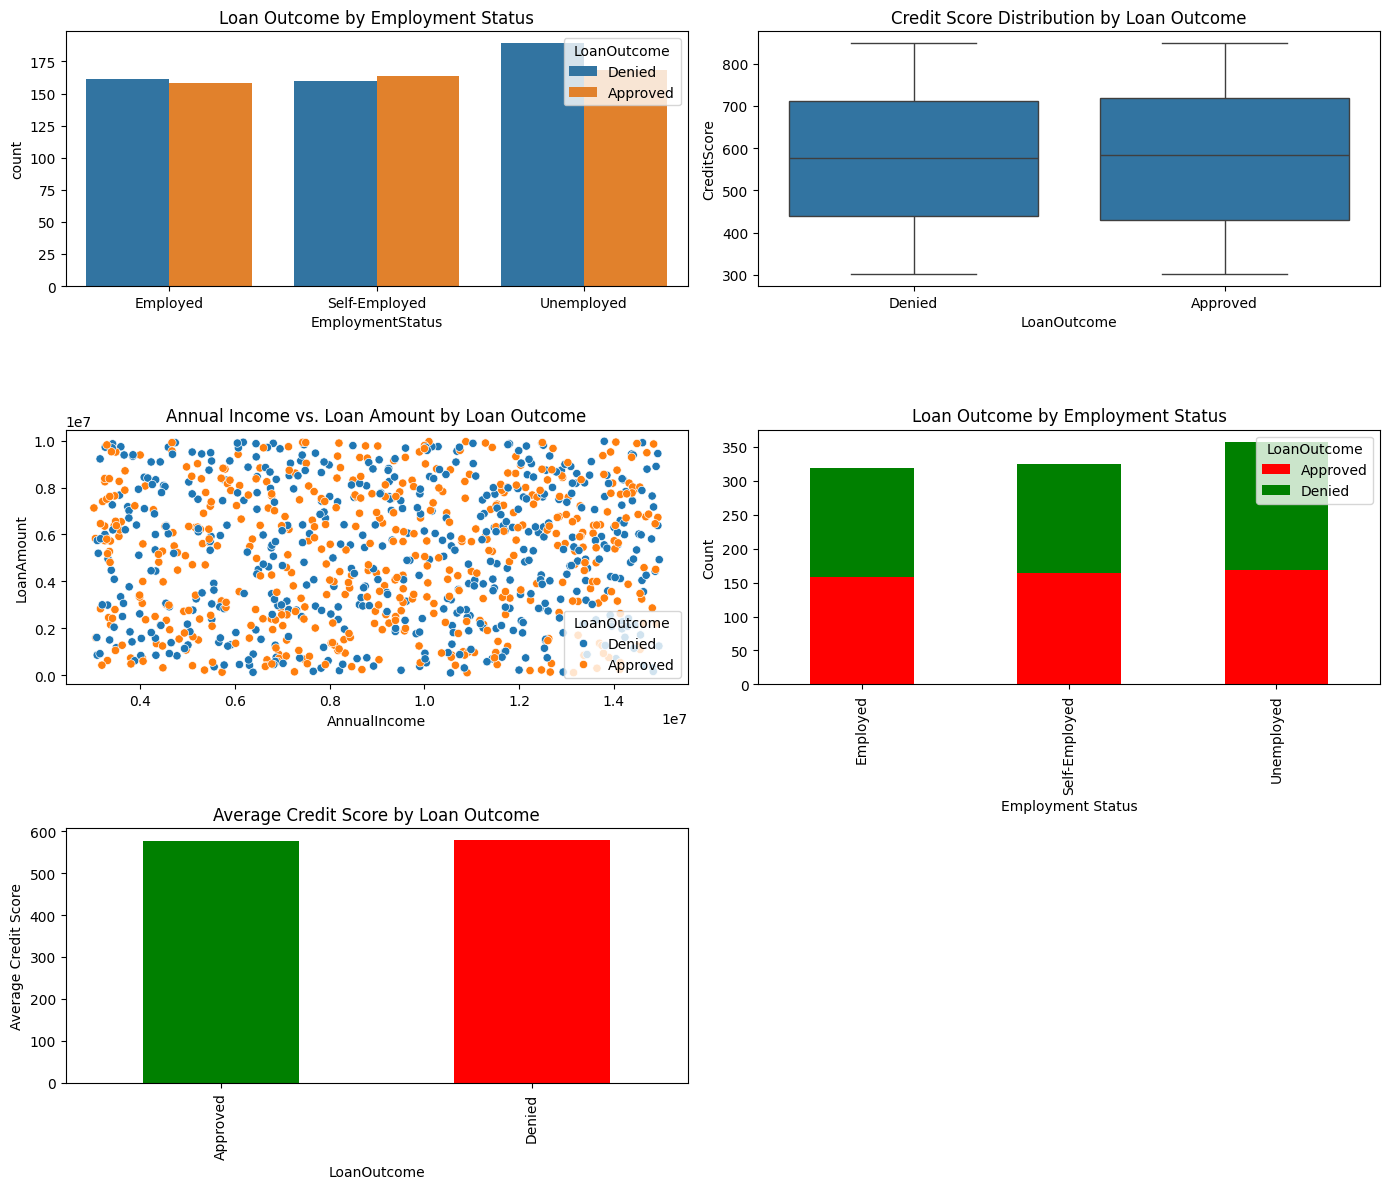

In [10]:

# Set up the figure and axes layout
fig, axes = plt.subplots(3, 2, figsize=(14, 12))  # 3 rows, 2 columns

# 1st Plot: Countplot for Loan Outcome by Employment Status
sns.countplot(x='EmploymentStatus', hue='LoanOutcome', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Loan Outcome by Employment Status')

# 2nd Plot: Boxplot for Credit Score by Loan Outcome
sns.boxplot(x='LoanOutcome', y='CreditScore', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Credit Score Distribution by Loan Outcome')

# 3rd Plot: Scatterplot for Annual Income vs. Loan Amount by Loan Outcome
sns.scatterplot(x='AnnualIncome', y='LoanAmount', hue='LoanOutcome', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Annual Income vs. Loan Amount by Loan Outcome')

# 4th Plot: Stacked Bar Plot for Loan Outcome by Employment Status
crosstab = pd.crosstab(df['EmploymentStatus'], df['LoanOutcome'])
crosstab.plot(kind='bar', stacked=True, color=['red', 'green'], ax=axes[1, 1])
axes[1, 1].set_title('Loan Outcome by Employment Status')
axes[1, 1].set_xlabel('Employment Status')
axes[1, 1].set_ylabel('Count')

# 5th Plot: Bar plot for Average Credit Score by Loan Outcome
credit_score_avg = df.groupby('LoanOutcome')['CreditScore'].mean()
credit_score_avg.plot(kind='bar', color=['green', 'red'], ax=axes[2, 0])
axes[2, 0].set_title('Average Credit Score by Loan Outcome')
axes[2, 0].set_ylabel('Average Credit Score')

# Remove empty plot in the bottom-right corner (if there are 5 plots)
axes[2, 1].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()


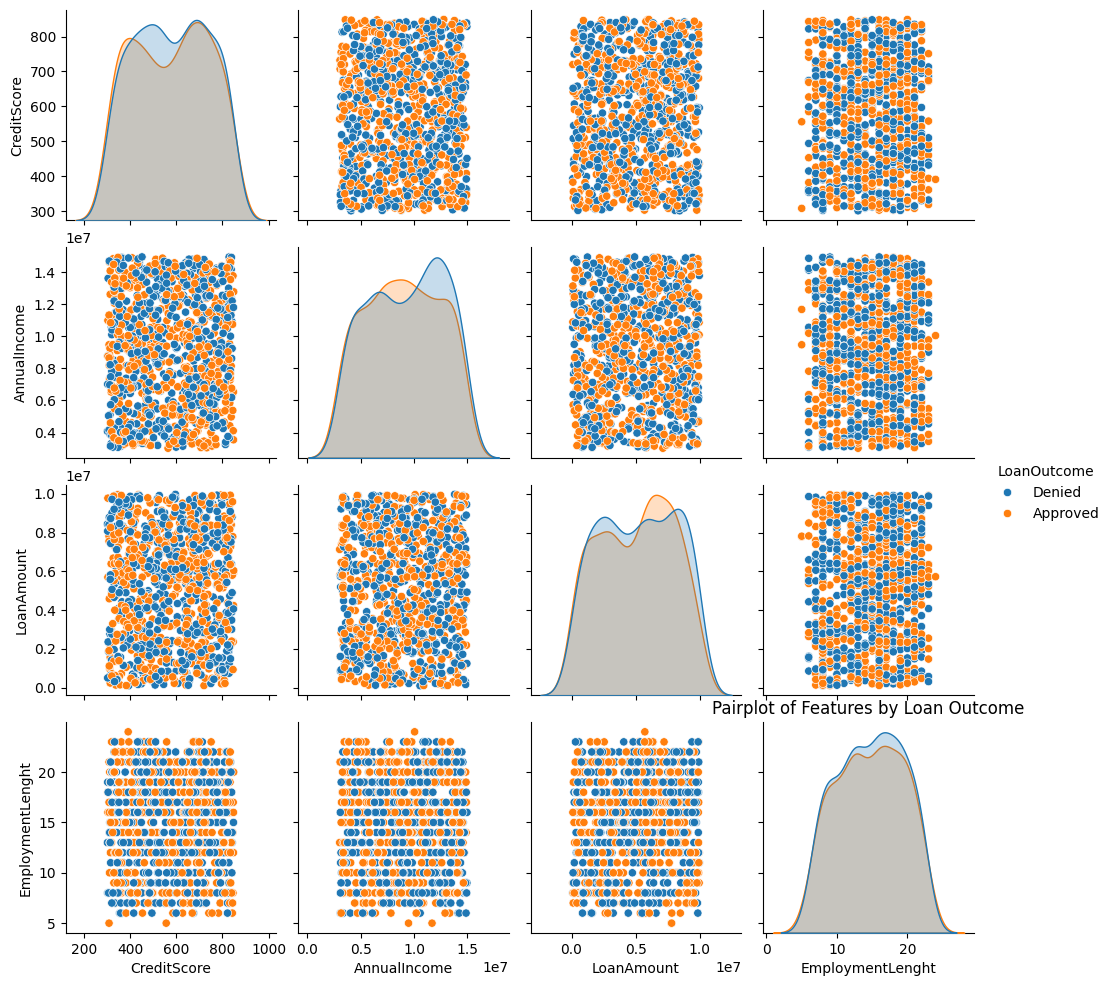

In [11]:
#Pairplot
sns.pairplot(df[['CreditScore', 'AnnualIncome', 'LoanAmount', 'EmploymentLenght','LoanOutcome']], hue='LoanOutcome')
plt.title('Pairplot of Features by Loan Outcome')
plt.show()

In [12]:
Approved=df[df['LoanOutcome']=='Approved']
Denied=df[df['LoanOutcome']=='Denied'] 

In [13]:

def hist_continuous_sea(df, continuous_features, bins=30, df2=None):
    # Set the style of Seaborn
    sns.set(style='whitegrid')

    for c in continuous_features:
        plt.figure(figsize=(8, 4))
        
        if df2 is not None:
            plt.subplot(1, 2, 1)
            plt.title('Approved', fontsize=20)
            sns.histplot(df[c], bins=bins, kde=True, color='blue', alpha=0.6)
            plt.xlabel(c, fontsize=15)
            plt.ylabel('Frequency', fontsize=15)

        if df2 is not None:
            plt.subplot(1, 2, 2)
            plt.title('Denied', fontsize=20)
            sns.histplot(df2[c], bins=bins, kde=True, color='red', alpha=0.6)
            plt.xlabel(c, fontsize=15)
            plt.ylabel('Frequency', fontsize=15)

        if df2 is not None:
            plt.suptitle(f'Distribution of {c}', size=25)
        else:
            plt.title(f'Distribution of {c}', size=25)
            
        plt.tight_layout()
        plt.show()

    return


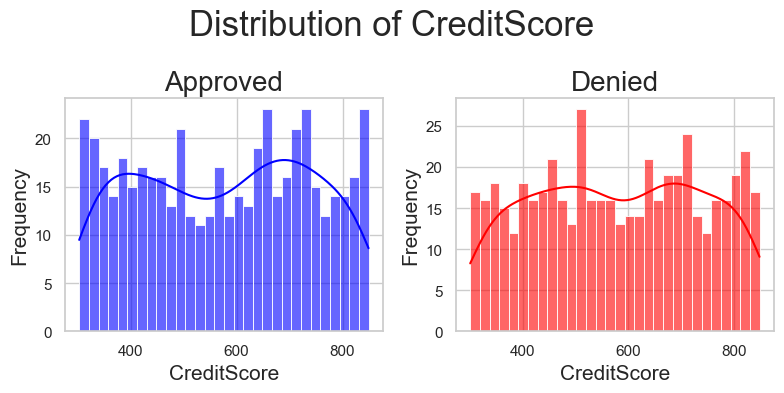

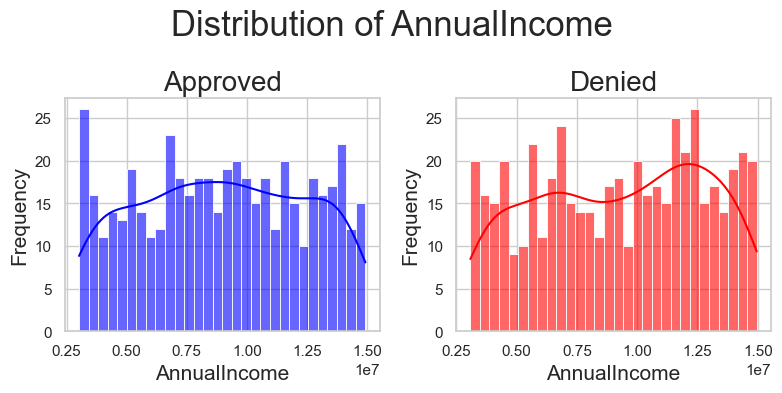

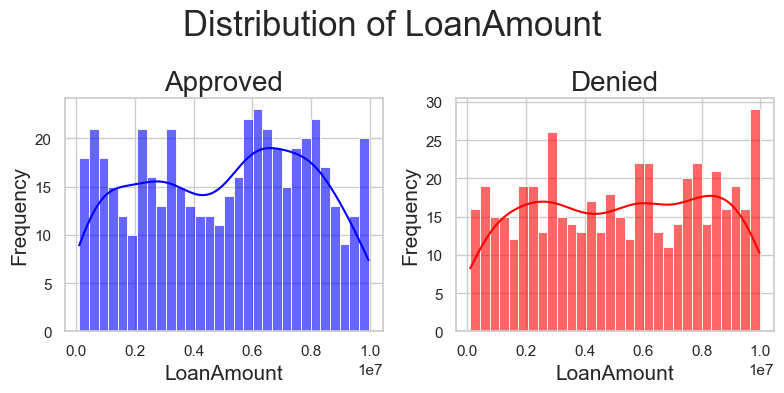

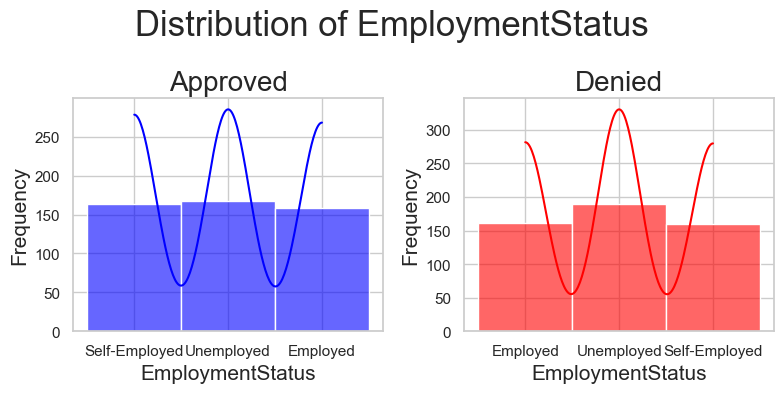

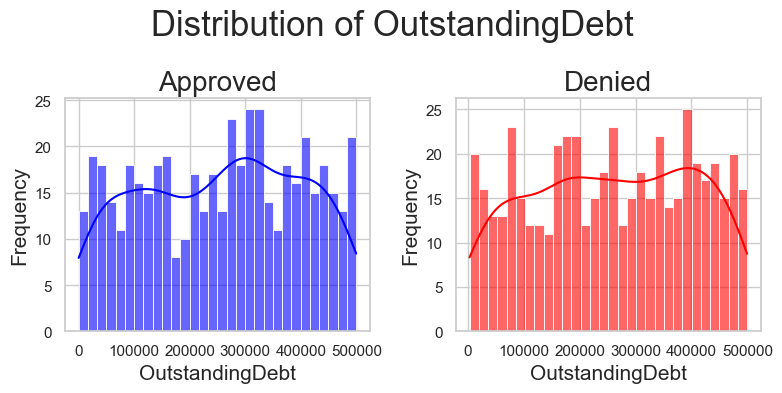

In [14]:
features=['CreditScore', 'AnnualIncome', 'LoanAmount','EmploymentStatus', 'OutstandingDebt']
hist_continuous_sea(Approved, features, df2=Denied)

checking of outliers

Text(0.5, 1.0, 'Annual Variation by loan outcome')

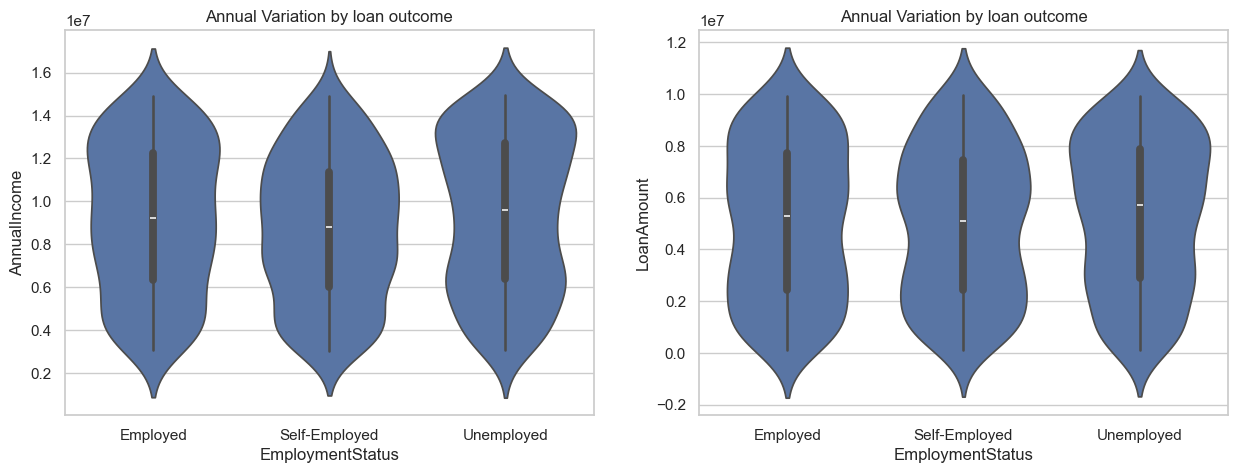

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.violinplot(x='EmploymentStatus', y= 'AnnualIncome', data=df)
plt.title('Annual Variation by loan outcome')

plt.subplot(1,2,2)
sns.violinplot(x='EmploymentStatus', y= 'LoanAmount', data=df)
plt.title('Annual Variation by loan outcome')

FEATURE ENGINEERING:
This section will be based on adding more engineering features/attributes to the data from pre-existing datas to help the machine converge fast and see patterns. the LoanOutcome column will be replaced with binary code(0,1) for machibe to understand and draw correlation between the Actual report and  predicted ones

In [16]:
df['DebtToIncome']=df['OutstandingDebt']/df['AnnualIncome']
df['LoanToIncome']=df['LoanAmount']/df['AnnualIncome']
df['DebtToLoan']=df['OutstandingDebt']/df['LoanAmount']

df['LoanOutcome']= df['LoanOutcome'].replace({
    'Denied': 0,
    'Approved': 1})

In [17]:
df.head()

,ApplicationDate,CreditScore,AnnualIncome,LoanAmount,EmploymentStatus,OutstandingDebt,EmploymentStartDate,LoanOutcome,EmploymentLenght,ApplicationYear,...,ApplicationDayOfYear,EmploymentStartYear,EmploymentStartMonth,EmploymentStartDay,EmploymentStartWeekday,EmploymentStartDayOfYear,ID,DebtToIncome,LoanToIncome,DebtToLoan
0,01/01/2021,655,6306291,417034,Employed,159749,11/24/2011,0,9.0,2021,...,1,2011,11,24,3,328,ccfdb393-c10d-11ef-af1f-88b111538715,0.025332,0.066130,0.383060
1,01/02/2021,652,7555169,5730135,Self-Employed,334035,12/25/2006,1,14.0,2021,...,2,2006,12,25,0,359,ccfdb394-c10d-11ef-8f73-88b111538715,0.044213,0.758439,0.058294
2,01/03/2021,490,9578220,1886511,Unemployed,159927,05/06/2006,1,15.0,2021,...,3,2006,5,6,5,126,ccfdb395-c10d-11ef-9b85-88b111538715,0.016697,0.196958,0.084774
3,01/04/2021,759,7697704,9468833,Unemployed,3438,01/22/2009,0,12.0,2021,...,4,2009,1,22,3,22,ccfdb396-c10d-11ef-b0b7-88b111538715,0.000447,1.230085,0.000363
4,01/05/2021,800,9040140,655286,Self-Employed,110166,10/19/2005,1,15.0,2021,...,5,2005,10,19,2,292,ccfdb397-c10d-11ef-a9db-88b111538715,0.012186,0.072486,0.168119


Data Preparation for training:
In this phase, we will be droping some columns that are of the type 'object' but still with high cardinality from the feature set of data  for proper optimization of the model, faster convergence, quick feadback loop, energy consumption and overfitting avoidance.

In [18]:
df.nunique()

ApplicationDate             1000
CreditScore                  467
AnnualIncome                1000
LoanAmount                  1000
EmploymentStatus               3
OutstandingDebt              997
EmploymentStartDate          873
LoanOutcome                    2
EmploymentLenght              20
ApplicationYear                3
ApplicationMonth              12
ApplicationDay                31
ApplicationWeekday             7
ApplicationDayOfYear         365
EmploymentStartYear           16
EmploymentStartMonth          12
EmploymentStartDay            31
EmploymentStartWeekday         7
EmploymentStartDayOfYear     342
ID                          1000
DebtToIncome                1000
LoanToIncome                1000
DebtToLoan                  1000
dtype: int64

Checking for correlation between features to know which to drop. If correlation exist between two or more columns only one needs to make it to the modeling phase to save energy consumption and avoid data leakage.

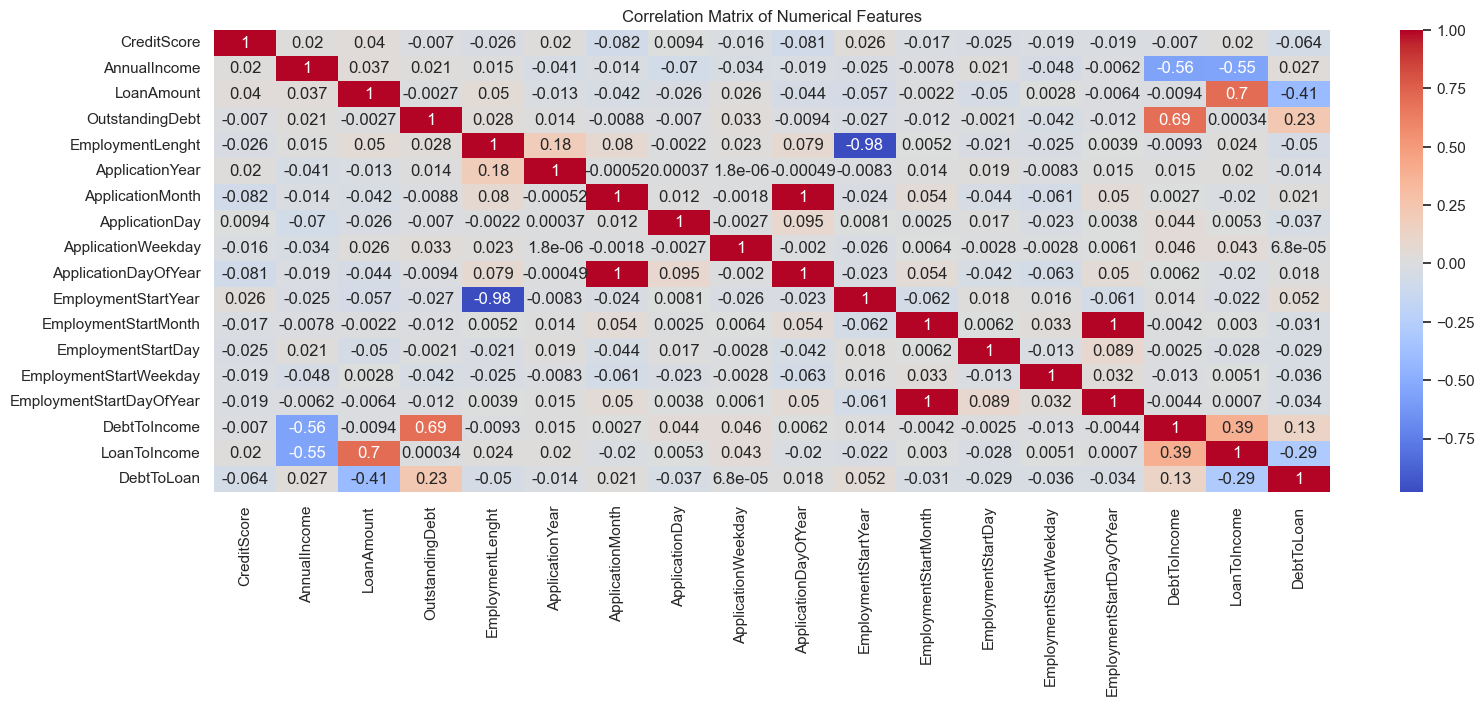

In [19]:
plt.figure(figsize=(18, 6))
corr_matrix = df[[ 'CreditScore', 'AnnualIncome', 'LoanAmount',
        'OutstandingDebt', 'EmploymentLenght', 'ApplicationYear',
       'ApplicationMonth', 'ApplicationDay', 'ApplicationWeekday',
       'ApplicationDayOfYear', 'EmploymentStartYear', 'EmploymentStartMonth',
       'EmploymentStartDay', 'EmploymentStartWeekday',
       'EmploymentStartDayOfYear', 'DebtToIncome', 'LoanToIncome',
       'DebtToLoan']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Dropping of (OutstandingDebt,LoanAmount) due to high correlation,  droping columns that are of high cardinality and the target column as well from the feature data.

In [21]:
# droping columns that are of high cardinality and the target column as well from the feature data.
X_use=df.drop(columns=['ApplicationDate','LoanOutcome','ID','OutstandingDebt','LoanAmount', 'EmploymentStartDate'])
# X_use=df.drop(columns=['LoanOutcome','ID'])

# X_use=X_drop.drop(columns=['OutstandingDebt','LoanAmount'], inplace=True)
y_use=df['LoanOutcome']


In [22]:
y_use.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: LoanOutcome
Non-Null Count  Dtype
--------------  -----
1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB


In [23]:
X_use.head()

,CreditScore,AnnualIncome,EmploymentStatus,EmploymentLenght,ApplicationYear,ApplicationMonth,ApplicationDay,ApplicationWeekday,ApplicationDayOfYear,EmploymentStartYear,EmploymentStartMonth,EmploymentStartDay,EmploymentStartWeekday,EmploymentStartDayOfYear,DebtToIncome,LoanToIncome,DebtToLoan
0,655,6306291,Employed,9.0,2021,1,1,4,1,2011,11,24,3,328,0.025332,0.066130,0.383060
1,652,7555169,Self-Employed,14.0,2021,1,2,5,2,2006,12,25,0,359,0.044213,0.758439,0.058294
2,490,9578220,Unemployed,15.0,2021,1,3,6,3,2006,5,6,5,126,0.016697,0.196958,0.084774
3,759,7697704,Unemployed,12.0,2021,1,4,0,4,2009,1,22,3,22,0.000447,1.230085,0.000363
4,800,9040140,Self-Employed,15.0,2021,1,5,1,5,2005,10,19,2,292,0.012186,0.072486,0.168119


 1.1 Model Selection - Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, roc_curve,
    recall_score, f1_score, confusion_matrix, classification_report
)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_use, y_use, test_size=0.2, random_state=42
)

In [26]:
# Identify numerical and categorical columns
numeric_f = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_f = X_train.select_dtypes(include=['object']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_f),
        ('cat', categorical_transformer, categorical_f)])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(max_iter=10000, random_state=42))
])

In [27]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'AnnualIncome', 'EmploymentLenght', 'DebtToIncome',
       'LoanToIncome', 'DebtToLoan'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['EmploymentStatus'], dtype='object'))])),
                ('log_reg',
                 LogisticRegression(max_iter=10000, random_state=42))])

In [28]:
# Make predictions
y_test_pred = pipeline.predict(X_test)
y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [29]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
 
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))



Accuracy: 0.5100
ROC AUC Score: 0.5086
Precision: 0.5143
Recall: 0.3600
F1 Score: 0.4235

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.66      0.57       100
           1       0.51      0.36      0.42       100

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.50       200



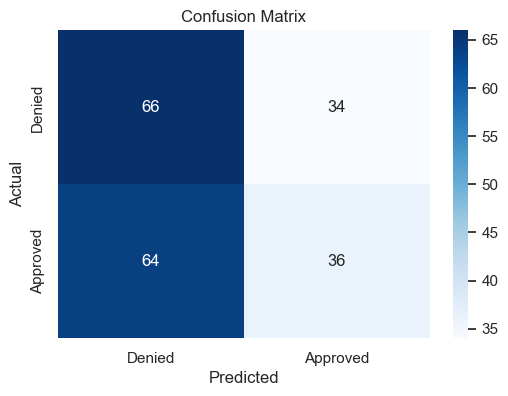

In [30]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

AUC: 0.5099999999999999


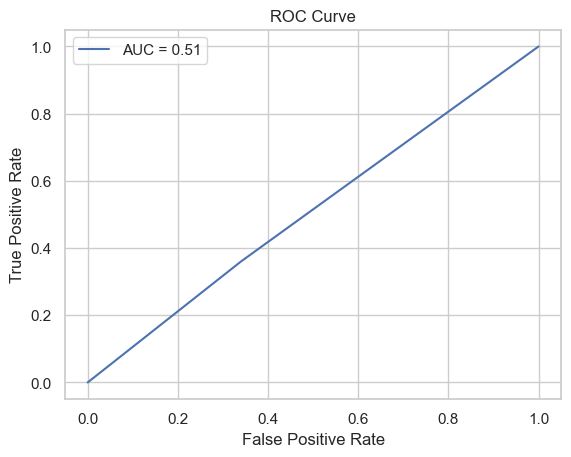

The ROC curve is a graphical representation of the true positive rate (recall) against the false positive rate.
 The AUC measures the entire two-dimensional area underneath the entire ROC curve. A higher AUC indicates a better performing model.
 An AUC (Area Under the Curve) of 0.555 indicates that your logistic regression model is only slightly better than random guessing


In [31]:
# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)
print("AUC:", auc)

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print('The ROC curve is a graphical representation of the true positive rate (recall) against the false positive rate.\n The AUC measures the entire two-dimensional area underneath the entire ROC curve. A higher AUC indicates a better performing model.\n An AUC (Area Under the Curve) of 0.555 indicates that your logistic regression model is only slightly better than random guessing')

optimizing the logistic model with hyperparameter tuning to see if there is any improvement

In [32]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for Logistic Regression hyperparameters
param_grid = {
    'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],     
    'log_reg__solver': ['liblinear', 'lbfgs'],     # Different solvers
    'log_reg__penalty': ['l1', 'l2'],              # Regularization type
    'log_reg__class_weight': [None, 'balanced'] ,
    # 'pca__n_components': range(5,15,3)
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)



In [33]:

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['CreditScore', 'AnnualIncome', 'EmploymentLenght', 'DebtToIncome',
       'LoanToIncome', 'DebtToLoan'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['EmploymentStatus'], dtype='object'))])),
                                       ('log_reg',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'log_reg__class_weight': [None, 'balanced'],
                         'log_reg__penalty': ['l1', 'l2'],
                         'log_reg__solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [34]:
best_pipeline = grid_search.best_estimator_
print(best_pipeline)
# Evaluate the tuned model on the test set
accuracy = best_pipeline.score(X_test, y_test)
print(f"\nTest set accuracy: {accuracy:.4f}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'AnnualIncome', 'EmploymentLenght', 'DebtToIncome',
       'LoanToIncome', 'DebtToLoan'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['EmploymentStatus'], dtype='object'))])),
                ('log_reg',
                 LogisticRegression(C=0.001, max_iter=10000, random_state=42,
                                    solver='liblinear'))])

Test set accuracy: 0.4600


In [35]:
# Make predictions
y_test_pred_g = best_pipeline.predict(X_test)
y_test_pred_proba_g = best_pipeline.predict_proba(X_test)[:, 1]

In [36]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred_g)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_g)
precision = precision_score(y_test, y_test_pred_g)
recall = recall_score(y_test, y_test_pred_g)
f1 = f1_score(y_test, y_test_pred_g)
 
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_g))



Accuracy: 0.4600
ROC AUC Score: 0.4830
Precision: 0.4231
Recall: 0.2200
F1 Score: 0.2895

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.70      0.56       100
           1       0.42      0.22      0.29       100

    accuracy                           0.46       200
   macro avg       0.45      0.46      0.43       200
weighted avg       0.45      0.46      0.43       200



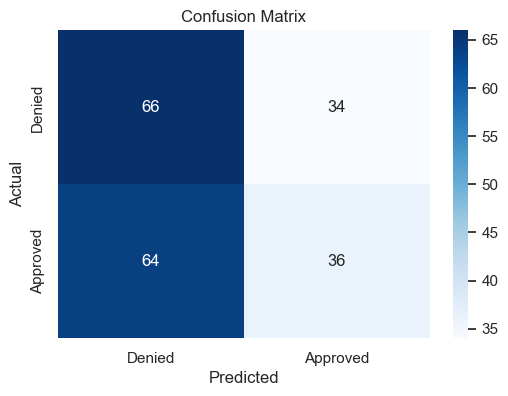

In [37]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The tuning is not showing any improvement.

1.2 Model selection : Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_use, y_use, test_size=0.2, random_state=42
)

In [40]:
acc_baseline = y_train_d.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5125


In [41]:
# Identify numerical and categorical columns
# numeric_f = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_f = X_train_d.select_dtypes(include=['object']).columns

# numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', numeric_transformer, numeric_f),
        ('cat', categorical_transformer, categorical_f)])

pipeline_d = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [42]:
pipeline_d.fit(X_train_d, y_train_d)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['EmploymentStatus'], dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [43]:
acc_train = pipeline_d.score(X_train_d, y_train_d)
acc_test = pipeline_d.score(X_test_d, y_test_d)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.515
Test Accuracy: 0.51


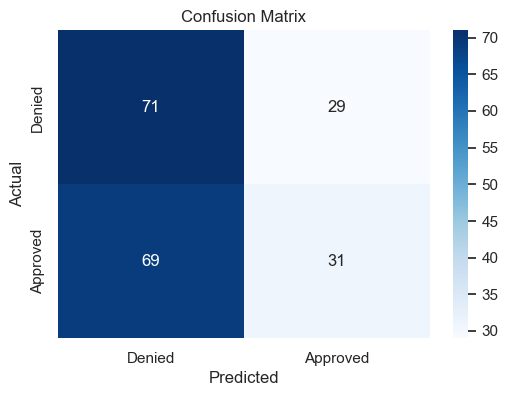


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.71      0.59       100
           1       0.52      0.31      0.39       100

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.49       200
weighted avg       0.51      0.51      0.49       200



In [44]:
# Compute confusion matrix
d_cm = confusion_matrix(y_test_d, pipeline_d.predict(X_test_d))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(d_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_d, pipeline_d.predict(X_test_d)))

Introduce parameters tunning  for decision tree

In [45]:
param_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'auto', 'sqrt', 'log2'],
    'classifier__class_weight': [None, 'balanced']
}


grid_search = GridSearchCV(estimator=pipeline_d, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [46]:
grid_search.fit(X_train_d, y_train_d)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['EmploymentStatus'], dtype='object'))])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [None, 'balanced'],
                         'classifier__criterion': ['gini', 'entropy',
                                                   'log_loss'],
                         'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__max_features': [None, 'auto', 'sqrt',
                                                      'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__splitter': ['best', 'random']},
             scoring='accuracy')

In [47]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Use the best model on the test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_d, y_test_d)
print(f"Test set accuracy: {test_accuracy:.4f}")

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__splitter': 'best'}
Best cross-validation accuracy: 0.4975
Test set accuracy: 0.4950


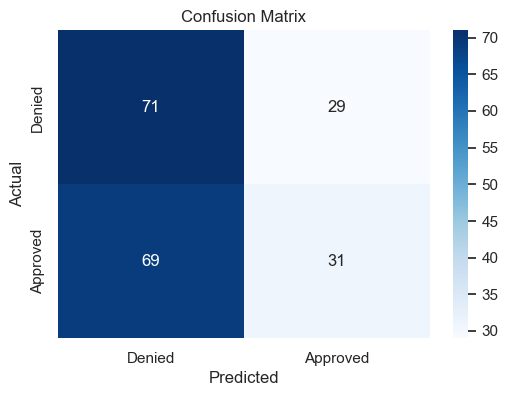


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.71      0.59       100
           1       0.52      0.31      0.39       100

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.49       200
weighted avg       0.51      0.51      0.49       200



In [48]:
# Compute confusion matrix
d_cm = confusion_matrix(y_test_d, pipeline_d.predict(X_test_d))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(d_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_d, pipeline_d.predict(X_test_d)))

1.3 Model selection: Random forest classifier


In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_use, y_use, test_size=0.2, random_state=42
)

In [51]:
acc_baseline = y_train_r.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5125


In [52]:
# pipeline_r = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore')),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])


# Identify numerical and categorical columns
numeric_f = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_f = X_train.select_dtypes(include=['object']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_f),
        ('cat', categorical_transformer, categorical_f)])

pipeline_r = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [53]:
pipeline_r.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'AnnualIncome', 'EmploymentLenght', 'DebtToIncome',
       'LoanToIncome', 'DebtToLoan'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['EmploymentStatus'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [54]:
acc_train = pipeline_r.score(X_train_r, y_train_r)
acc_test = pipeline_r.score(X_test_r, y_test_r)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.47


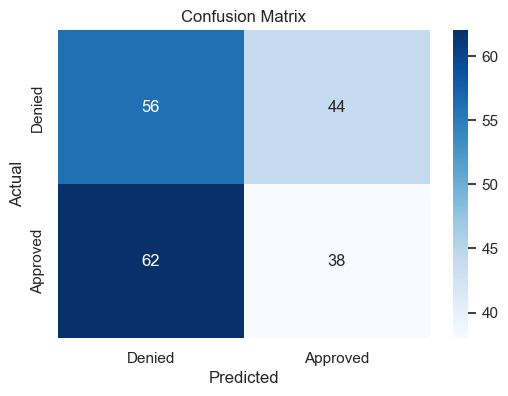


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.56      0.51       100
           1       0.46      0.38      0.42       100

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200



In [55]:
# Compute confusion matrix
r_cm = confusion_matrix(y_test_r, pipeline_r.predict(X_test_r))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(r_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_r, pipeline_r.predict(X_test_r)))

Since the training accuracy is 1.0 but performing very poor on test dataset then this is overfitting, we need tofind the best by tuning

In [56]:
# Define the parameter grid
params = {
    'classifier__n_estimators':range(25, 100, 25),  # Random forest n_estimators to tune
    'classifier__max_depth': range(10, 50, 10),   # Random forest max_depth to tune
    'classifier__min_samples_split': range(2, 15, 2),       # Minimum number of samples to split a node
    'classifier__min_samples_leaf': [1, 2, 4,6,8,10]
}

# Instantiate GridSearchCV with 5-fold cross-validation
grid_search= GridSearchCV(
    pipeline_r,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [57]:
# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score from grid search
print(f"Best Params: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Best Params: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best Cross-Validation Score: 0.4925


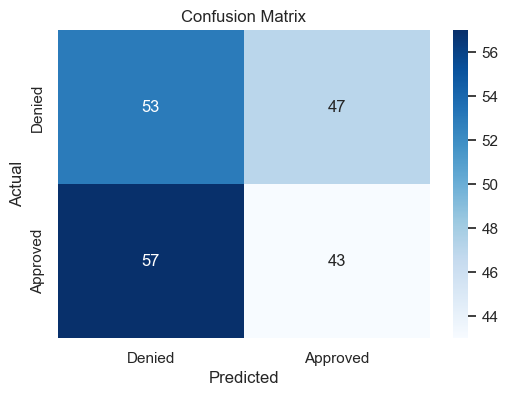


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.56      0.51       100
           1       0.46      0.38      0.42       100

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200



In [58]:
# Compute confusion matrix
r_cm = confusion_matrix(y_test_r, grid_search.predict(X_test_r))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(r_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_r, pipeline_r.predict(X_test_r)))

1.4 Model selection: XGboost

In [59]:
import xgboost as xgb

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X_use, y_use, test_size=0.2, random_state=42
)

In [61]:
acc_baseline = y_train_r.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5125


In [62]:



# Identify numerical and categorical columns
numeric_f = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_f = X_train.select_dtypes(include=['object']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_f),
        ('cat', categorical_transformer, categorical_f)])

pipeline_x = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
    objective='binary:logistic',   
    eval_metric='logloss',         
    use_label_encoder=False,       
    random_state=42))
])

In [63]:
pipeline_x.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CreditScore', 'AnnualIncome', 'EmploymentLenght', 'DebtToIncome',
       'LoanToIncome', 'DebtToLoan'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['EmploymentStatus'], dtype='object'))])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=N...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [64]:
y_pred = pipeline_x.predict(X_test)

In [65]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
 
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.4900
ROC AUC Score: 0.4830
Precision: 0.4889
Recall: 0.4400
F1 Score: 0.4632

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       100
           1       0.49      0.44      0.46       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200



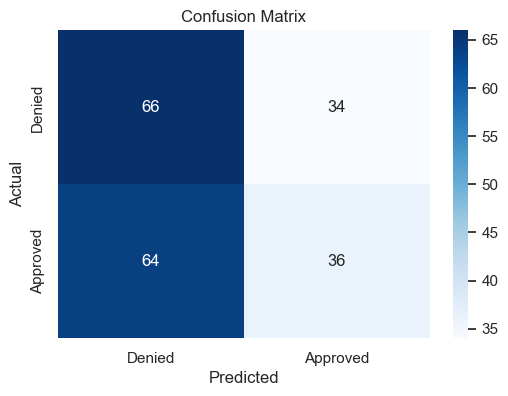

In [66]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Tunning the xgboost

In [67]:
# Define the parameter grid
params = {
    'classifier__n_estimators':range(25, 100, 25),  # Random forest n_estimators to tune
    'classifier__max_depth': range(10, 50, 10),   # Random forest max_depth to tune
    'classifier__learning_rate': [0.1],     
    'classifier__subsample':[0.8],
    'classifier__colsample_bytree':[0.8]
}

# Instantiate GridSearchCV with 5-fold cross-validation
grid_search= GridSearchCV(
    pipeline_x,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [68]:
# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score from grid search
print(f"Best Params: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
Best Cross-Validation Score: 0.47125000000000006


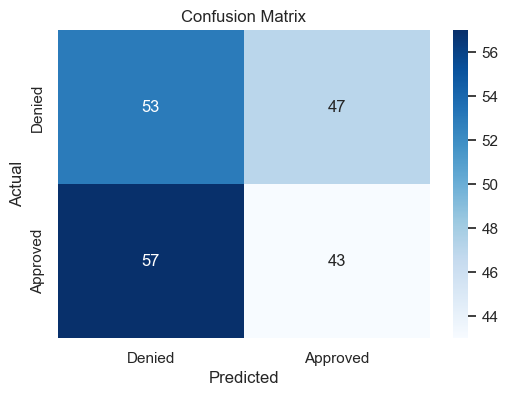


Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.56      0.51       100
           1       0.46      0.38      0.42       100

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200



In [69]:
# Compute confusion matrix
x_cm = confusion_matrix(y_test_r, grid_search.predict(X_test_r))

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(r_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test_r, pipeline_r.predict(X_test_r)))

Final model :Logistic Regression initially performed better than the others with an accuracy of 0.51 without tuning, so weare training finally with logistic regression

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, roc_curve,
    recall_score, f1_score, confusion_matrix, classification_report
)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X_use, y_use, test_size=0.2, random_state=42
)

In [72]:
# Identify numerical and categorical columns
numeric_f = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_f = X_train.select_dtypes(include=['object']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_f),
        ('cat', categorical_transformer, categorical_f)])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(max_iter=10000, random_state=42))
])
pipeline.fit(X_train, y_train)


# Make predictions
y_test_pred = pipeline.predict(X_test)
y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [73]:

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
 
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Accuracy: 0.5100
ROC AUC Score: 0.5086
Precision: 0.5143
Recall: 0.3600
F1 Score: 0.4235

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.66      0.57       100
           1       0.51      0.36      0.42       100

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.50       200



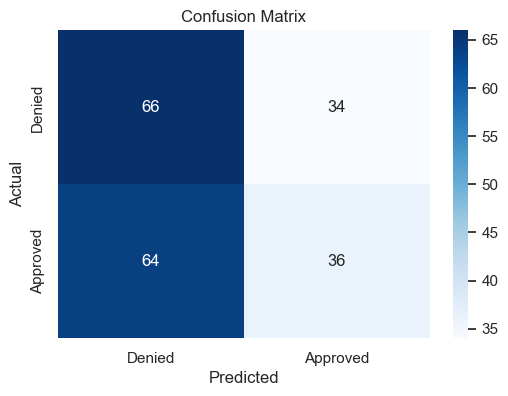

In [74]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Model interpretation:

In [75]:
import numpy as np
#Getting out  the feature names from the pipeline (including those from OneHotEncoder)
categorical_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_f)
numeric_feature_names = numeric_f
all_feature_names = np.hstack([numeric_feature_names, categorical_feature_names])
coefficients = pipeline.named_steps['log_reg'].coef_[0]


In [76]:
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

In [77]:
feature_importance['Importance'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

In [78]:
#Most significant feature on the impact of loan outcome
print(feature_importance)

                          Feature  Coefficient  Importance
5                      DebtToLoan    -0.128580    0.128580
8     EmploymentStatus_Unemployed    -0.094145    0.094145
3                    DebtToIncome     0.090644    0.090644
4                    LoanToIncome    -0.089346    0.089346
2                EmploymentLenght    -0.061588    0.061588
1                    AnnualIncome    -0.044936    0.044936
7  EmploymentStatus_Self-Employed     0.037285    0.037285
0                     CreditScore     0.022306    0.022306
6       EmploymentStatus_Employed     0.022127    0.022127


In [79]:
#Most significant feature on the impact of loan outcome
print(feature_importance[:1])

      Feature  Coefficient  Importance
5  DebtToLoan     -0.12858     0.12858


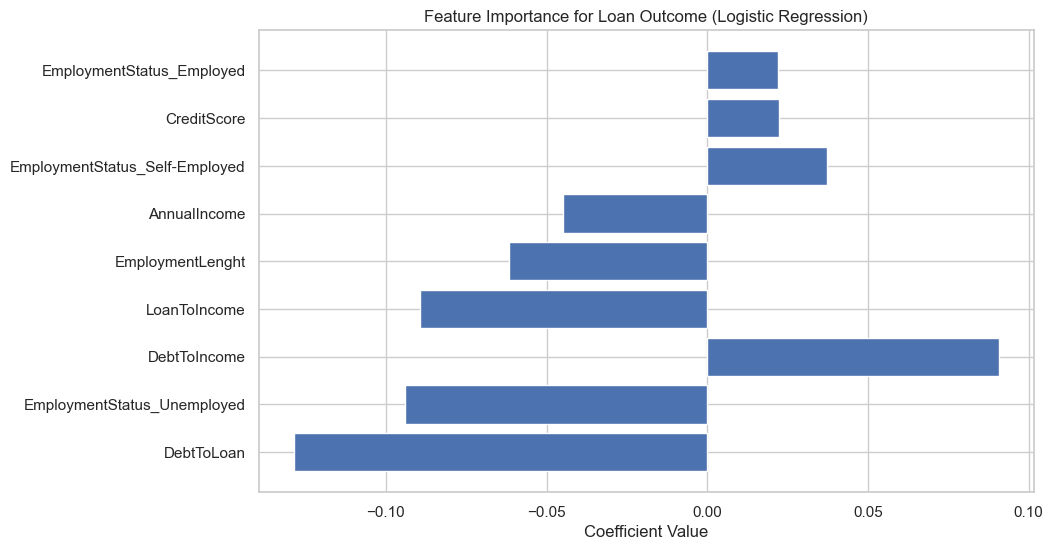

In [80]:

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance for Loan Outcome (Logistic Regression)')
plt.show()